# No-glue-code

In [1]:
] activate "."

  Activating project at `~/PhD/AdvancedHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using LogDensityProblems
using LogDensityProblemsAD
using DynamicPPL
using ForwardDiff
using Random
using LinearAlgebra

#Plotting
using PyPlot

#What we are tweaking
using Revise
using AdvancedHMC

## Model

In [3]:
# Just a simple Neal Funnel
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DefaultContext()))

In [18]:
typeof(funnel_model)

Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}

## Turing interface

In [16]:
context = funnel_model.context
varinfo = DynamicPPL.VarInfo(funnel_model, context)
ℓ = LogDensityProblemsAD.ADgradient(DynamicPPL.LogDensityFunction(varinfo, funnel_model, context))
lπ = Base.Fix1(LogDensityProblems.logdensity, ℓ)
∂lπ∂θ(x) = LogDensityProblems.logdensity_and_gradient(ℓ, x)
metric =  DiagEuclideanMetric(d)
hamiltonian = AdvancedHMC.Hamiltonian(metric, lπ, ∂lπ∂θ)

Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]), kinetic=GaussianKinetic())

In [19]:
struct Sampler
    metric
    integrator
    adaptor
    proposal
end

Sampler(ϵ, TAP) = begin
    metric =  DiagEuclideanMetric(d)
    integrator = Leapfrog(ϵ)
    proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(TAP, integrator))
    
    Sampler(
        metric,
        integrator,
        adaptor,
        proposal)
end

Sampler

In [20]:
initial_θ = randn(21)
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
sampler = Sampler(initial_ϵ, 0.95)

Sampler(DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]), Leapfrog(ϵ=1.6), StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.95, state.ϵ=1.6),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
), HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=1.6), tc=GeneralisedNoUTurn{Float64}(10, 1000.0))))

In [23]:
function StatsBase.sample(model::DynamicPPL.Model, sampler::Sampler, n_samples::Int, n_adapts::Int;
                initial_θ=initial_θ, kwargs...)
    ctxt = model.context
    vi = DynamicPPL.VarInfo(model, ctxt)
    
    # We will need to implement this but it is going to be 
    # Interesting how to plug the transforms along the sampling
    # processes
    
    #vi_t = Turing.link!!(vi, model)
    
    ℓ = LogDensityProblemsAD.ADgradient(DynamicPPL.LogDensityFunction(vi, model, ctxt))
    ℓπ(x) = LogDensityProblems.logdensity(ℓ, x)
    ∂lπ∂θ(x) = LogDensityProblems.logdensity_and_gradient(ℓ, x)
    
    metric = sampler.metric
    integrator = sampler.integrator
    adaptor = sampler.adaptor
    proposal = sampler.proposal
    hamiltonian = AdvancedHMC.Hamiltonian(metric, lπ, ∂lπ∂θ)
    
    return StatsBase.sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)
end    

LoadError: error in method definition: function StatsBase.sample must be explicitly imported to be extended

In [22]:
n_samples, n_adapts = 10_000, 1_000
sample(funnel_model, sampler, n_samples, n_adapts; initial_θ=initial_θ)

LoadError: MethodError: no method matching sample(::Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}, ::Sampler, ::Int64, ::Int64; initial_θ::Vector{Float64})

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


[0mClosest candidates are:
[0m  sample([91m::AbstractRNG[39m, ::Any, [91m::AbstractMCMC.AbstractSampler[39m, ::Any; kwargs...)
[0m[90m   @[39m [35mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/F9Hbk/src/[39m[90m[4mlogdensityproblems.jl:43[24m[39m
[0m  sample(::Any, [91m::AbstractMCMC.AbstractSampler[39m, [91m::AbstractMCMC.AbstractMCMCEnsemble[39m, ::Integer, [91m::Integer[39m; kwargs...)
[0m[90m   @[39m [35mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/F9Hbk/src/[39m[90m[4msample.jl:54[24m[39m
[0m  sample(::Any, [91m::AbstractMCMC.AbstractSampler[39m, ::Any; kwargs...)
[0m[90m   @[39m [35mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/F9Hbk/src/[39m[90m[4msample.jl:15[24m[39m
[0m  ...


## Sampling

In [13]:
# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 10_000, 1_000
initial_θ = randn(21)
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.95, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:01
  iterations:                                   10000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      15
  is_accept:                                    true
  acceptance_rate:                              0.9429472344154662
  log_density:                                  -60.09829978233757
  hamiltonian_energy:                           68.99870162156931
  hamiltonian_energy_error:                     0.09210815757290902
  max_hamilto

## Plotting

In [14]:
theta_mchmc = [sample[1] for sample in samples]
x10_mchmc = [sample[10+1] for sample in samples];

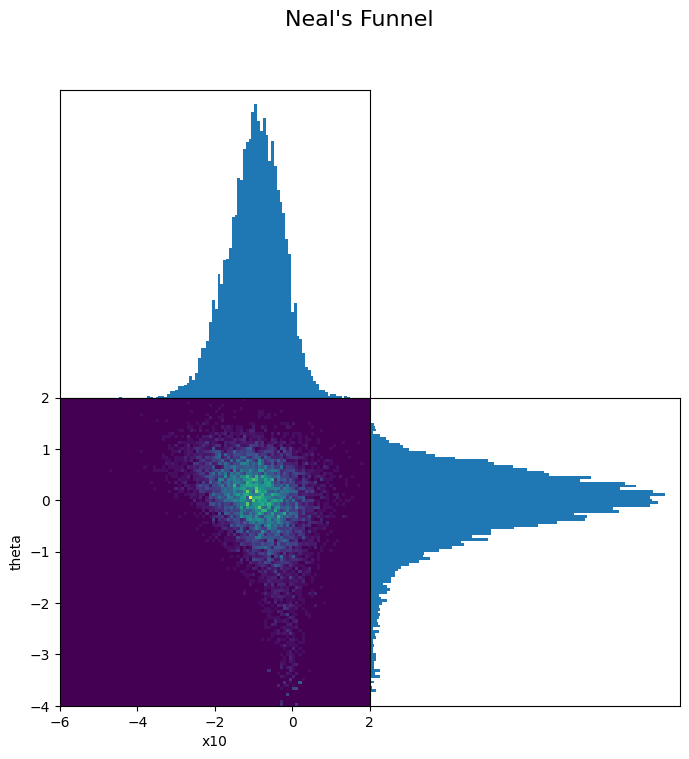

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");